# Dalbyover 59.459  

Reading LAS wireline log file, calculate sonic velocity from arrival times. 

The tool used for sonic logs have recievers at 0.60, 0.80 and 1.00m according to [factsheet](https://github.com/TobbeTripitaka/Dalbyover/blob/master/Sonic-slimhole_TRGS8068.pdf). The header of the [LAS files](https://github.com/TobbeTripitaka/Dalbyover/tree/master/data) states that the measurements are in _m_ and _km_. Modified sonic log used.  

The upper 40m, the most interesting depths fo us, is unfortunately missing. The well needed a steel casting to not collaps and sonic logs are not correct. 

Instructions: 

<blockquote>In [the] data set I have performed depth correction based on the strong gamma peaks in the lower part of the well, and using TCDS3719-Dalbyover1 as the reference because we know for certain that this well log was recorded from ground level. I had to adjust TRGS8068-Dalbyover4 up by 69 cm and TRGS8068-Dalbyover5 up by 7 cm. After depth correction I merged the two files at 113,68 m depth where their gamma values coincided.</blockquote>

## Import Python modules and packages

In [1]:
#Plot in document
%matplotlib inline
#%matplotlib

import numpy as np
import pandas as pd
import numpy.lib.recfunctions
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import gridspec
import scipy.signal as signal
import math

plt.style.use('ggplot')
#plt.switch_backend('nbagg')
plt.rcParams['figure.figsize']=12,8


## Import data from textfiles

First read in the datasets, wireline logs and plug samples:

Create a pandas dataframe, handy for plotting and statistical analysis. Print an overview of the data. 

In [2]:
def read_LAS(file_name,file_header=33):
    '''
    Read LAS file from Robertson Geologging WinLogger
    Specify file name and header line nr.  
    '''
    in_file_A = pd.read_csv(file_name, header=file_header,delim_whitespace=True, 
                        na_values=['1.#J',0,-999.25,-999999.00000,'...'])
    
    # LAS files have an extra carachter that adds an extra column
    in_file = in_file_A[in_file_A.columns[:-1]]
    in_file.columns = in_file_A.columns[1:]
    in_file=in_file.dropna(axis=1,how='all')
    in_file[in_file < min_value] = np.nan
    return in_file
    
def read_porper(file_name):
    '''
    Read csv with data from plug samples.   
    '''
    in_file = pd.read_csv(file_name,usecols=['Plug', 'Depth','Volume',
                                             'Weight','Porosity','Density (grain)',
                                            'Density (bulk)', 'Permeability'])
    in_file.rename(columns={'Plug': 'ID', 'Depth': 'DEPTH','Volume': 'VOLUME', 'Weight': 'WEIGHT',
                           'Porosity': 'POROSITY', 'Density (grain)': 'GRAIN',
                            'Density (bulk)': 'BULK', 'Permeability' : 'PERMEABILITY'}, inplace=True)
    return in_file    

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

# In files 
in_sonic = 'data/59-459_Sonic3_Final04.LAS'
in_electric = ['data/TCDS3719-Dalbyover1.LAS', 'data/TCDS3719-Dalbyover2.LAS']
in_gamma = 'data/INDG1832-Dalbyover3.LAS'
#Old sonic logs: 'data/TRGS8068-Dalbyover5.LAS', 'data/TRGS8068-Dalbyover4.LAS'
#sonic = pd.concat([read_LAS(in_sonic[1],38), read_LAS(in_sonic[0],38)])

#Crop out values lowar than:
min_value = -1

# Read and merge sonic logs
sonic = read_LAS(in_sonic,46)
sonic.columns = ['DEPTH', 'TXRX1','TXRX2','TXRX3','R1R2','R2R3','R1R3','SONIC','NGTR','NANA']

# Read and join electric logs
electric = pd.merge(read_LAS(in_electric[0]), read_LAS(in_electric[1]), 
                    on='DEPTH', how='outer',suffixes=('_E1', '_E2'))

# Read gamma log
gamma = read_LAS(in_gamma,32)
gamma.columns = ['DEPTH', 'NGAM_G','COND_G']

# Merge electric and gamma
el_gamma = pd.merge(electric, gamma, on='DEPTH', how='outer')

#... and sonic
data = pd.merge(el_gamma, sonic, on='DEPTH', how='outer')

#... and plug samples
porper = read_porper('data/Dalbyover-1 porperm.csv')
data = pd.merge(data, porper, on='DEPTH', how='outer')

# Sort dataframe
data = data.sort_values('DEPTH', ascending=True)
data = data.dropna(axis=1,how='all')

#For peace of mind, at this stage all data is changed to SI units, conversion is made in plot functions
data['COND_E1'] = data['COND_E1']/10000 #uS/cm -> S/m
data['COND_E2'] = data['COND_E2']/10000 #uS/cm -> S/m
data['COND_G'] = data['COND_G']/1000 #mS/m -> S/m
data['PERMEABILITY'] = data['PERMEABILITY']/1000 #mD ->D
data['POROSITY'] = data['POROSITY']/100 #Percent->fraction

# Save a file with sonic and electric data
data.to_csv('log_data.txt')

# How many meters did the cassing of the hole reach?
casing = 45

# Print overview
print list(data.columns.values), '\n'
print data.describe()
#print_full(data)

['DEPTH', 'NGAM_E1', 'COND_E1', 'TEMP_E1', 'TEMP_E2', 'COND_E2', 'NGAM_E2', 'NGAM_G', 'COND_G', 'TXRX1', 'TXRX2', 'TXRX3', 'R1R2', 'R2R3', 'R1R3', 'SONIC', 'NGTR', 'NANA', 'ID', 'VOLUME', 'WEIGHT', 'POROSITY', 'GRAIN', 'BULK', 'PERMEABILITY'] 

              DEPTH       NGAM_E1       COND_E1       TEMP_E1       TEMP_E2  \
count  34896.000000  34586.000000  34557.000000  34561.000000  34605.000000   
mean     174.295050      8.890979      0.035700     10.499044     11.119097   
std      100.737624      4.674639      0.013161      1.630407      1.786431   
min       -0.190000      1.330000      0.001086      7.270000      8.380000   
25%       87.057500      6.100000      0.037998      8.770000      9.470000   
50%      174.295000      7.960000      0.040186     10.340000     11.130000   
75%      261.532500     10.340000      0.041892     12.020000     12.620000   
max      350.630000     67.800000      0.160493     13.380000     14.600000   

            COND_E2       NGAM_E2        NG

## Test sonic data
Remake velocity computations.

In [3]:
# M s to us
M = 10**6 

# Calculate velocity from spacing (20cm) and arrival time difference
np.seterr(divide='ignore')
v1 = M*0.2/(data['TXRX2']-data['TXRX1'])
v2 = M*0.2/(data['TXRX3']-data['TXRX2'])

#print v1.describe()

# Calculate a few exemples
sample_depths = [10,50,100,300]
sample_depths.sort()

for sample in sample_depths:
    sample_data = data.loc[data['DEPTH'] == sample]
    v1 = M*0.20/(sample_data['TXRX2']-sample_data['TXRX1']) #R2-R1
    v2 = M*0.20/(sample_data['TXRX3']-sample_data['TXRX2']) #R3-R2
    v3 = M*0.40/(sample_data['TXRX3']-sample_data['TXRX1']) #R3-R2
    
    print 'v at %.2fm is calculated to %.2f (R2-R1)' \
    ', %.2f (R3-R2) and %.2f (R3-R1). Sonic is %.2f' % (sample,v1,v2,v3, 1000*sample_data['SONIC'])


v at 10.00m is calculated to nan (R2-R1), nan (R3-R2) and nan (R3-R1). Sonic is nan
v at 50.00m is calculated to 2134.02 (R2-R1), 2868.62 (R3-R2) and 2447.38 (R3-R1). Sonic is 2484.17
v at 100.00m is calculated to 2243.16 (R2-R1), 2465.48 (R3-R2) and 2349.07 (R3-R1). Sonic is 2352.50
v at 300.00m is calculated to 2536.78 (R2-R1), 2396.93 (R3-R2) and 2464.88 (R3-R1). Sonic is 2466.00


OK, looks OK. Note that the Sonic is the average of R2R1, R3R2 and R3R1.

## Make test plots

Make plots of the raw data, and also introduce a basic non-liear filter to remove spikes for some logs. 

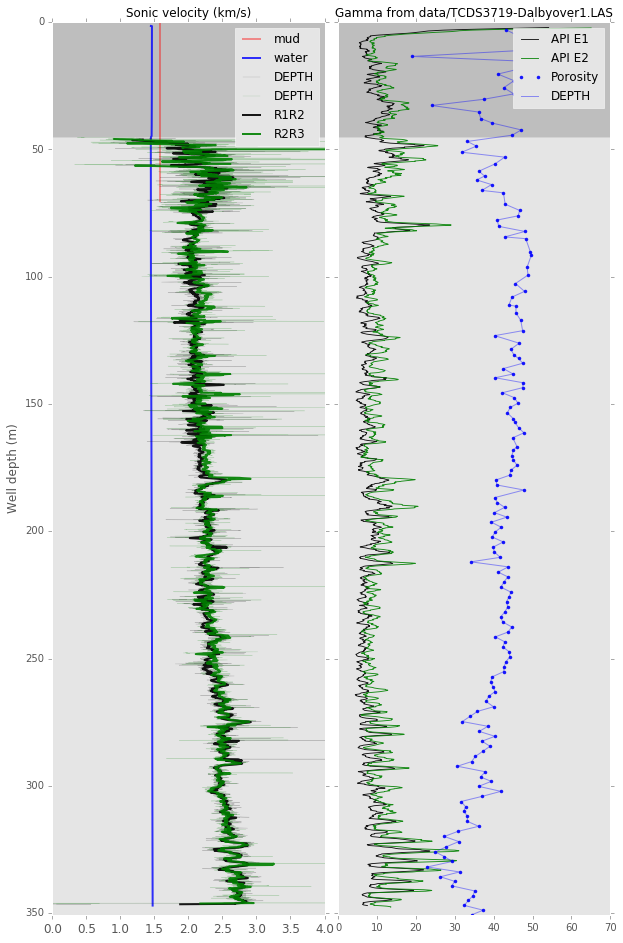

In [21]:
# Define functions
def well_plot(x,y=data['DEPTH'],label=None,lw=1,color='black',alpha=0.9):
    '''
    Using matplotlib to plot a well log. 
    '''
    plt.plot(x,y,label = label,lw = lw, color=color, alpha=alpha)
    plt.ylim(max(data['DEPTH']),0)
    return

def casing_plot():
    '''
    Plot casing , label='casing'
    '''
    return plt.axhspan(0,casing, facecolor='k', alpha=0.17)

def smooth_filter(raw,kernel=60,med_kernel=5):
    '''
    Apply mean filter, set window size. Median filter removes spikes and outlayers
    '''
    raw = signal.medfilt(raw, kernel_size=med_kernel)
    return pd.rolling_mean(raw, kernel)

# Apply smoothing filter kernel is median window size, must be odd
kernel=60

fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(wspace=0.05)

ax1 = plt.subplot(121)
ax1.set_ylim(ax1.get_ylim()[::-1]) 
plt.title('Sonic velocity (km/s)', fontsize = 12)
plt.ylabel('Well depth (m)', fontsize = 12)

#Plot mud velocity 5,300 feet/s
avg_temp = 0.5*(data['TEMP_E1']+data['TEMP_E2'])
plt.axvline(x=1.581, color='red', label='mud',lw=2,alpha=0.4,ymin=0.8)
plt.plot((1404.3+4.7*avg_temp+0.04*avg_temp**2)/1000,data['DEPTH'], lw=2, color='blue', label='water', alpha=0.8)

#well_plot(C*data['R1R2'],data['DEPTH']+0.1,'TEST!')

#def well_plot(x,y=data['DEPTH'],well_label='x',well_lw=1,well_color='black',well_alpha=0.9):

#Plot raw data
well_plot(data['R1R2'],data['DEPTH']+0.1, lw=0.3, alpha=0.3)
well_plot(data['R2R3'],data['DEPTH']-0.1, lw=0.3, color='green', alpha=0.3)
#R1R3

#Plot filtered data
well_plot(smooth_filter(C*data['R1R2'],kernel),data['DEPTH']+0.1, 
          label = 'R1R2',lw=2)
well_plot(smooth_filter(C*data['R2R3'],kernel),data['DEPTH']-0.1, 
          label = 'R2R3',lw=2, color='green')

casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.xlim(0, 4)
plt.grid()
plt.legend()

# Plot gamma
ax2 = plt.subplot(122, sharey=ax1)
plt.title('Gamma from %s'%in_electric[0], fontsize = 12)
well_plot(smooth_filter(data['NGAM_E1'],101), lw=0.9, label='API E1')
well_plot(smooth_filter(data['NGAM_E2'],101), lw=0.9, color ='green', label='API E2')

plt.xlim(0, 30)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
casing_plot()

# Plot porosity
mask = np.isfinite(data['POROSITY'])
plt.plot(100*data['POROSITY'][mask],data['DEPTH'][mask],'.b', alpha=0.9,label='Porosity')
plt.plot(100*data['POROSITY'][mask],data['DEPTH'][mask],'b-', alpha=0.4)

plt.xlim(0, 70)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.grid()
plt.legend()

plt.show()


Velocity for [water](http://www.sciencedirect.com/science/article/pii/S030156299800091X) as a function of temperature is plotted in blue. 
Sonic velocities in drill mud is in the range of 185-189 $\mu/ ft$. See [Petrowiki](http://petrowiki.org/Porosity_evaluation_with_acoustic_logging). The lower value is typical for salt mud and showed as a red line in sonic plot.

## Gamma for correlance
TCDS3719-Dalbyover1.LAS and TCDS3719-Dalbyover2.LAS contains conductivity, temperature and gamma logs. 

Gamma logs are used among other to correlate the datasets in depth. According to Kristian Sloth, the best dataset to trust is the  TCDS3719-Dalbyover1.LAS

A closer look at the gamma logs:

          NGAM_E1   NGAM_E2    NGAM_G      NGTR
NGAM_E1  1.000000  0.813882  0.058149  0.434795
NGAM_E2  0.813882  1.000000  0.065101  0.454611
NGAM_G   0.058149  0.065101  1.000000  0.033056
NGTR     0.434795  0.454611  0.033056  1.000000

NGAM_E1 7.96 0.0
NGTR 9.84634 1.88634
NGAM_G 8.94 0.98
NGAM_E2 10.25 2.29


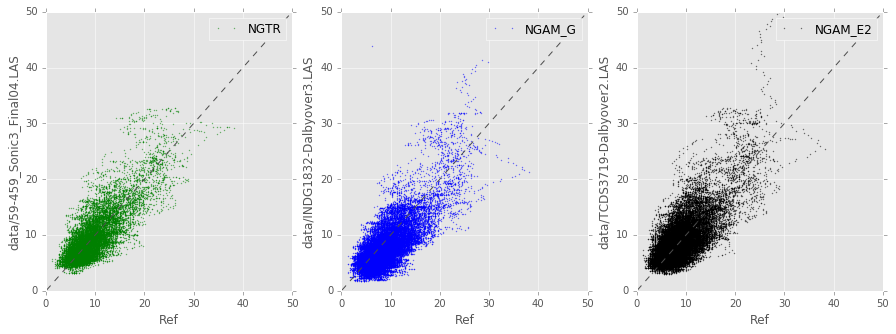

In [22]:
def corr_plot(x,corr_color,corr_label,y_label,sub):
    dc_corr = data[i].median()-ref_median # REMOVE DC
    ax = plt.subplot(sub)
    plt.plot(ref, x-dc_corr, corr_color, label = corr_label, alpha = 0.4, markersize=2,markevery=1)
    plt.legend()
    plt.xlabel('Ref', fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    ax.plot([-75, 75], [-75, 75], ls="--", c=".3")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    return; 

# According to Kristian Sloth, the most reliable dataset 
ref= data['NGAM_E1'].values
ref_median = data['NGAM_E1'].median()

#List correlation
gamma_corr = pd.concat([data['NGAM_E1'], data['NGAM_E2'], 
                        data['NGAM_G'], data['NGTR']], axis=1)

corr = gamma_corr.corr(method='pearson', min_periods=1)
print corr
print

for i in ['NGAM_E1','NGTR','NGAM_G','NGAM_E2']:
    i_median = data[i].median()
    print i, i_median,  i_median-ref_median

# Plot correlation
fig = plt.figure(figsize=(15,5))
corr_plot(smooth_filter(data['NGTR']),'g.','NGTR',in_sonic,131)
corr_plot(smooth_filter(data['NGAM_G']),'b.','NGAM_G',in_gamma,132)
corr_plot(smooth_filter(data['NGAM_E2']),'k.','NGAM_E2',in_electric[1],133)
               
plt.show()


The plot suggest that the gamma logs fit each other somehow, and we can assume that the logs are adjusted coectely in depth. The gamma logs for correlation is corrected for dc by subtraction of the median value. Hoverver NGAM_G and NGTR are not correlated at all:

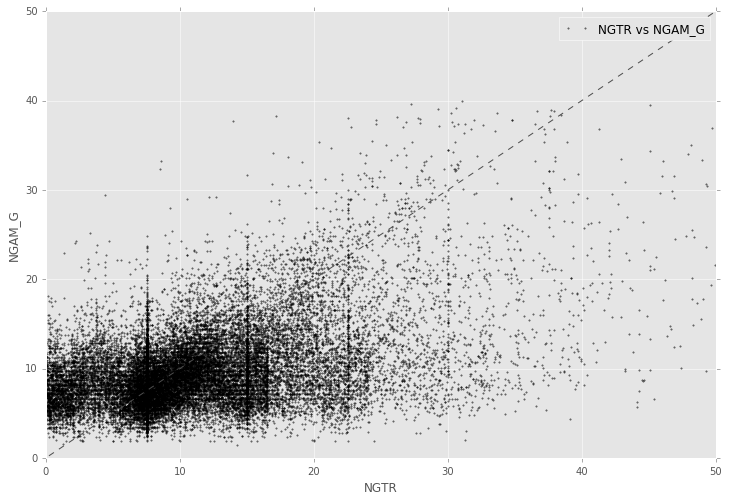

In [23]:
plt.plot(data['NGTR'],data['NGAM_G'], '.k', label = 'NGTR vs NGAM_G', alpha = 0.5, markersize=3,markevery=1)
plt.legend()
plt.xlabel('NGTR', fontsize = 12)
plt.ylabel('NGAM_G', fontsize = 12)
plt.plot([-75, 75], [-75, 75], ls="--", c=".3")
plt.xlim(0, 50)
plt.ylim(0, 50)

plt.show()

It apears that there is a rather good correlance between the electric logs, but not between electric and sonic log, especially for lower values. 

## Inspect and interpolate plug sample data (porosity and permeability)

The plug samples hare used for porosity and pereability. The samples are interpolated and filtered as:

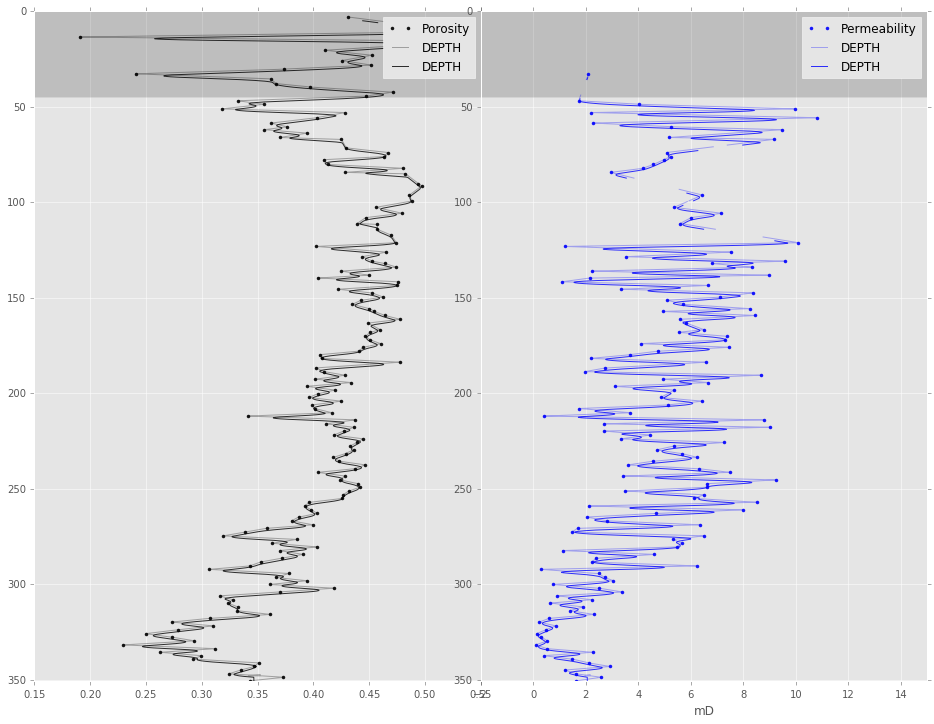

In [24]:
fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(wspace=0)

ax1 = plt.subplot(121)
mask_POR = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask_POR],data['DEPTH'][mask_POR],'.k', alpha=0.9,label='Porosity')
POR_inter = data['POROSITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
plt.plot(POR_inter,data['DEPTH'],'k-', alpha=0.3)
#plt.xlim(-2,15)
plt.plot(smooth_filter(POR_inter,200),data['DEPTH'],'k-', alpha=0.8)
plt.ylim(max(data['DEPTH']),0)
casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

ax2 = plt.subplot(122)
mask_PERM = np.isfinite(data['PERMEABILITY'])
plt.plot(1000*data['PERMEABILITY'][mask_PERM],data['DEPTH'][mask_PERM],'.b', alpha=0.9,label='Permeability')
PERM_inter = data['PERMEABILITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
plt.plot(1000*PERM_inter,data['DEPTH'],'b-', alpha=0.3)
plt.xlim(-2,15)
plt.plot(smooth_filter(1000*PERM_inter,200),data['DEPTH'],'b-', alpha=0.8)
plt.xlabel('mD', fontsize = 12)

casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

plt.show()


Continous datasets are saved in new arrays, inter_POR and inter_PERM.

## How would the data relate to classification and literature?

Porosity and permeability can indicate lithology, as shown by Akbar et al:

<img src="images/Akbar_et_al.png" alt="Drawing" style="width: 400px;"/>

And ploted with plug data:

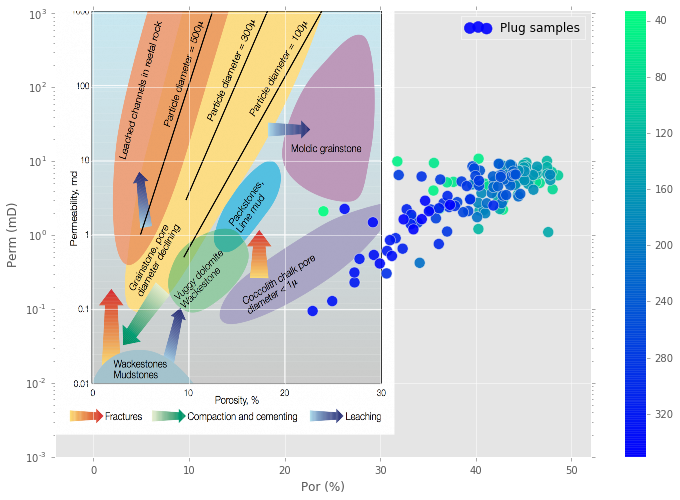

In [25]:
PERM_inter = data['PERMEABILITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
POR_inter = data['POROSITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')

fig = plt.figure(figsize=(12,8))
ax = plt.gca()

mask_POR = np.isfinite(data['POROSITY'])
color_depth = data['DEPTH'][mask_POR]
#cm = plt.cm.get_cmap('RdYlBu')

por_per = ax.scatter(100*data['POROSITY'][mask_POR], 1000*data['PERMEABILITY'][mask_POR], 
                     c=color_depth, s=120, label='Plug samples', cmap='winter_r', alpha=0.9)
ax.set_yscale('log')
cbar=plt.colorbar(por_per)
cbar.ax.invert_yaxis() 
plt.xlabel('Por (%)', fontsize = 12)
plt.ylabel('Perm (mD)', fontsize = 12)
plt.xlim(-4, 52)
plt.ylim(0.001, 1100)
plt.legend()
legend = ax.get_legend()
legend.legendHandles[0].set_color('blue')

im = plt.imread('images/Akbar_et_al.png')
plt.imshow(im, extent=[-4.5, 31.4, 0.002, 1500],interpolation='bicubic')

plt.show()

## Make plot of electric data

Now a better look at the electric data:

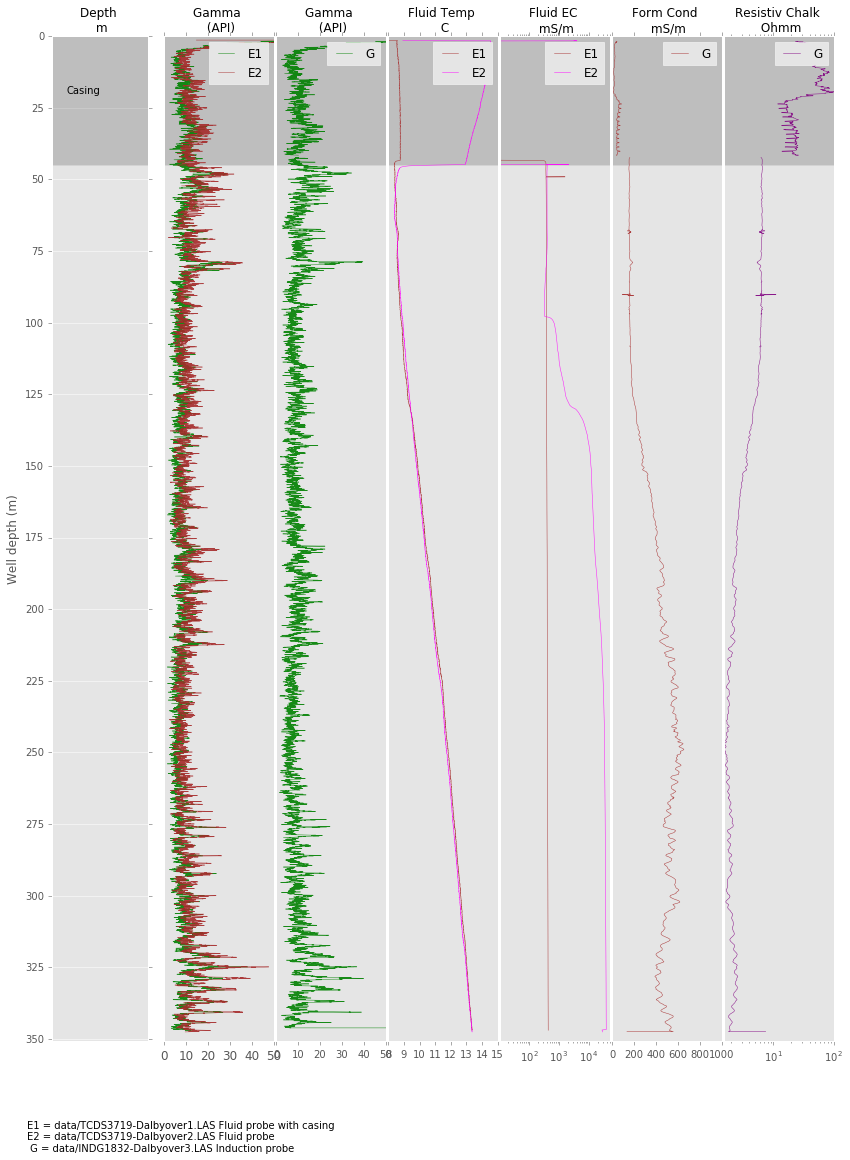

In [27]:
# Apply smoothing filter kernel is median window size, must be odd
kernel=99

fig = plt.figure(figsize=(14,18))
fig.subplots_adjust(wspace=0.025)
plt.xticks(rotation='vertical')
plt.figtext(.1, .04, 'E1 = %s Fluid probe with casing \nE2 = %s Fluid probe \n G = %s Induction probe'%(in_electric[0],in_electric[1],in_gamma))

#Depth
ax0 = plt.subplot(181) 
well_plot(data['DEPTH'],data['DEPTH'], lw=0.1, alpha=0.0)
plt.ylabel('Well depth (m)', fontsize = 12)
plt.title('Depth \n m', fontsize = 12)
casing_plot()
ax0.axes.get_xaxis().set_visible(False)
plt.yticks(np.arange(0, max(data['DEPTH']), 25.0))
ax0.text(15, 20, 'Casing', fontsize=10,color='k')


#Gamma NG TCDS og NG casing
ax1 = plt.subplot(172)
well_plot(data['NGAM_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='E1')
well_plot(data['NGAM_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E2')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax1.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Natural Gamma
ax2=plt.subplot(173)
well_plot(data['NGAM_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='G')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax2.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Temp
ax3=plt.subplot(174)
well_plot(data['TEMP_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(data['TEMP_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
plt.title('Fluid Temp \n C', fontsize = 12)
plt.xlim(8, 15)
ax3.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#fluid conductivity
ax4=plt.subplot(175)
well_plot(10000*data['COND_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(10000*data['COND_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
# in casing...
plt.title('Fluid EC \n mS/m', fontsize = 12)
ax4.set_xscale('log')
plt.xlim(0, 50000)
ax4.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#formation conductivity
ax5=plt.subplot(176)
well_plot(1000*data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='G')
plt.title('Form Cond \n mS/m', fontsize = 12)
plt.xlim(0, 1000)
ax5.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#R
ax6=plt.subplot(177)
well_plot(1/data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'purple', label='G')
plt.title('Resistiv Chalk \n Ohmm', fontsize = 12)
ax6.set_xscale('log')
plt.xlim(0, 100)
ax6.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)

plt.show()


## Make conversions, theory section

We can get some relations in place: 

Formation factor can be estimated in two ways; from porosity and cementation and from conductivity measurements: 

$$F=\frac{R_O}{R_W}=\frac{a}{\phi^m}=\frac{\tau}{\phi}$$

Where F is formation factor, $R_O$ is resistivity of rock and $R_W$ is resistivity of porefluid. $\phi$ is porosity and $m$ is the curious cementation factor that will be discussed later. $a$ is usuallly set to 1. $\tau$ is $L/L_a$.

We can solve for m:

$$m = \frac{ln(\frac{a*R_W}{R_O})}{ln \phi}$$

With this information we can involve Archie's law and try to model the porosity based on electric logs, parameters and plug samples. 

$$C_t = \frac{1}{a} C_w \phi^m S_w^n$$

$C_t$ is the electrical conductivity of the fluid saturated rock
$a$ is the Tortuosity factor
$C_w$ is the electrical conductivity of the brine
$\phi$ is the porosity
$m$ is the cementation exponent
$S_w$ is the brine saturation
$n$ is saturation exponen

Kozeny’s equation relates porosity. permeability and pore space as (Kozeny, 1927): 

$$k=c \frac{\phi}{s^2}$$

and Carman’s model for the tortuous path (Carman, 1937):

$$c_R=\frac{1}{k_0\tau}$$

where $k_0$ is close to 2.

Kozeny’s factor ($c$) is often assumed to be 0.25, but it might actually be related to the porosity and geometry of the rock. The model from Mortensen et. al. (1998) connects Kozeny’s factor with porosity for chalk depending on shape. For circular cavities:

$$c_\phi=(4\cos(\frac{1}{3}\arccos(\phi\frac{8^2}{\pi^3}-1)+\frac{4}{3}\pi)+4)^{-1}$$

but with square tubes $c_\phi$ would rather be: 

$$c_\phi=(4\cos(\frac{1}{3}\arccos(\phi*2-1)+\frac{4}{3}\pi)+4)^{-1}$$

Klinkenberg permeability is estimated from gas permeability as:

$$K_k=0.52K_a^{1.083}$$
 
Conductivity/resistivity measurements must also be corrected for temperature. It's not clear if this is done for the dataset and should be tried and known as a posible source of error. An empirical conversion can be made with Hilchie’s equation:

$$R_{WT2}=R_{WT1}\frac{T1+X}{T2+X}$$ and where $$ X=10^{-0.340396 \log_{10} R_{WT1} − 0.641427}$$

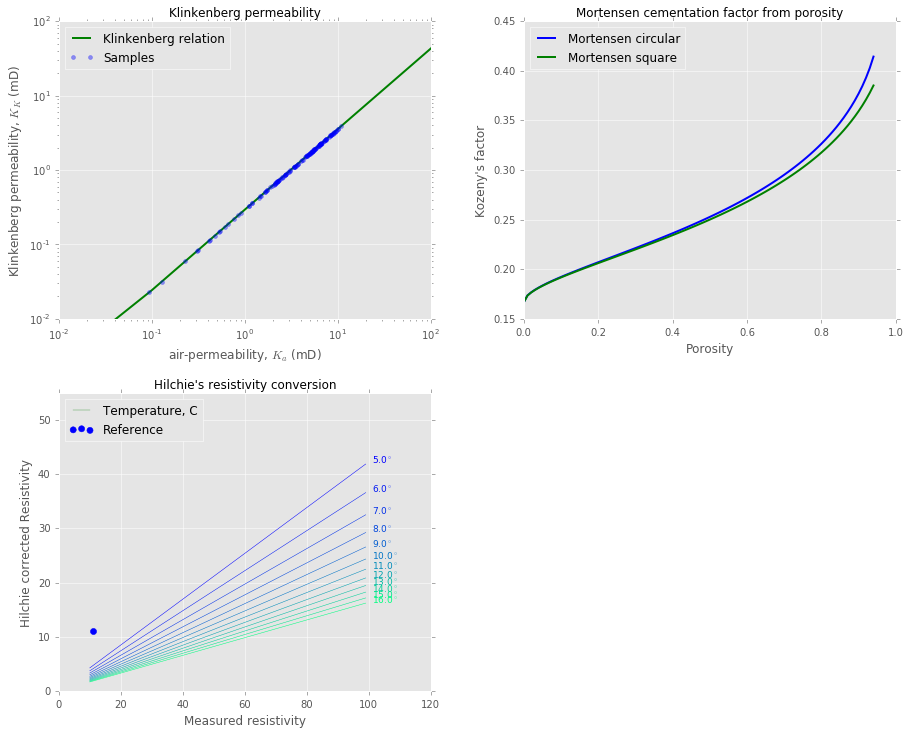

In [29]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

# Equations
# Klinkenberg
klinkenberg = lambda k: 0.52*k**1.083

#Mortensen circular (1) and square (2)
mortensen1 = lambda c_phi: 1./(4*math.cos((1./3)*math.acos(c_phi*64/(math.pi**3)-1)+4*math.pi/3)+4)
mortensen2 = lambda c_phi: 1./(4*math.cos((1./3)*math.acos(c_phi*2-1)+4*math.pi/3)+4)

# Hilchie. Set reference sample
def hilchie(r_array, t_array, R1, T1):
    H = 10.**(-0.340396*math.log10(R1)+0.641427)
    h_array = r_array*(T1+H)/(t_array+H)
    return h_array
    
#Plot exemples
ax1 = plt.subplot(2, 2, 1)
plt.title('Klinkenberg permeability', fontsize = 12)
per_range = np.arange(0, 0.1, 0.0001)
klinkenberg_range = np.array([klinkenberg(c) for c in per_range])
klinkenberg_samples = np.array([klinkenberg(c) for c in data['PERMEABILITY'][mask_PERM]])
plt.plot(1000*per_range,1000*klinkenberg_range,'g',lw=2,label="Klinkenberg relation")
plt.plot(1000*data['PERMEABILITY'][mask_PERM],1000*klinkenberg_samples,'.b', markersize=8, alpha = 0.4,label="Samples")
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.legend(loc=2)
plt.ylabel('Klinkenberg permeability, $K_K$ (mD)', fontsize = 12)
plt.xlabel('air-permeability, $K_a$ (mD)', fontsize = 12)

ax2=plt.subplot(2, 2, 2)
plt.title('Mortensen cementation factor from porosity', fontsize = 12)

por_range = np.arange(0, 0.95, 0.01)
mortensen1_range = np.array([mortensen1(c) for c in por_range])
mortensen2_range = np.array([mortensen2(c) for c in por_range])
plt.plot(por_range,mortensen1_range,'b',lw=2,label="Mortensen circular")
plt.plot(por_range,mortensen2_range,'g',lw=2,label="Mortensen square")
plt.ylabel("Kozeny's factor", fontsize = 12)
plt.xlabel('Porosity', fontsize = 12)
plt.legend(loc=2)
klinkenberg_perm = np.array([klinkenberg(c) for c in PERM_inter])
Kozeny_factor = np.array([mortensen1(c) for c in (0.01*POR_inter)])

ax3=plt.subplot(2, 2, 3)
plt.title("Hilchie's resistivity conversion", fontsize = 12)
res_in = np.arange(10, 100, 1, dtype=np.float) 
t_step_array=np.ones_like(res_in)
hilchie_temps = np.arange(5,17,1, dtype=np.float) # Plot temperatures
color_idx = np.linspace(0, 1, len(hilchie_temps))
ref_D = 1
R1= res_in[ref_D]
T1 = t_step_array[ref_D]

for i, T2 in zip(color_idx, hilchie_temps):
    hilchie_range = hilchie(res_in, t_step_array*T2, R1, T1)
    ax3.plot(res_in, hilchie_range, color=plt.cm.winter(i) ,lw=0.5)
    ax3.text(101, hilchie(100,T2,R1,T1), str(T2)+'$^\circ$', fontsize=9, color=plt.cm.winter(i))

ax3.scatter(R1,hilchie(R1,T1,R1,T1),color='b',marker='.', s=150, label='Reference')

ax3.plot(res_in+10000,hilchie_range,'g',lw=0.3, label='Temperature, C')
ax3.legend(loc=2)
plt.ylabel('Hilchie corrected Resistivity', fontsize = 12)
plt.xlabel('Measured resistivity', fontsize = 12)
plt.xlim(0, 120)
plt.ylim(0, 55)

#Correct Data:
klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])

#    ref_index = (data['DEPTH']==ref_D).argmax()
#    R1=r_array[ref_index]
#    T1 = t_array[ref_index]
#for electric in ['E1','E2','G']:
#    data['RES_'+electric +'_hilchie'] = 1/np.array([hilchie(t) for t in data['COND_' + electric]])

#data[] = np.array([klinkenberg(c) for c in PERM_inter])
#klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])
#klinkenberg_inter = np.array([klinkenberg(c) for c in PERM_inter])

plt.show()


## Cross-plot data

Look at relation Resistivity Formation Factor vs porosity. 

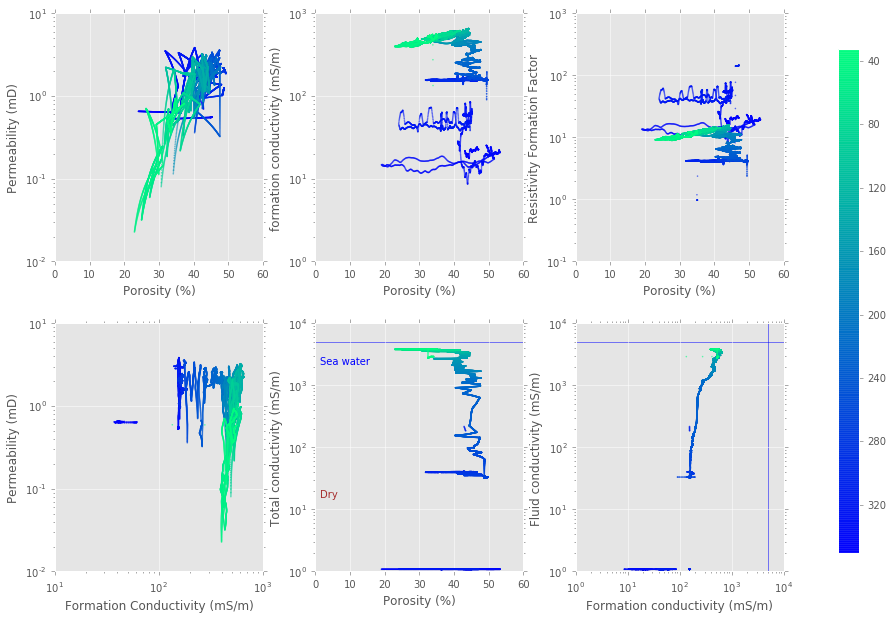

In [30]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax1 = plt.subplot(2, 3, 1)
ax1.scatter(100*POR_inter, 1000*klinkenberg_inter, c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax1.set_yscale('log')
plt.ylabel('Permeability (mD)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

ax4 = plt.subplot(2, 3, 4)
ax4.scatter(1000*data['COND_G'], 1000*klinkenberg_inter, c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax4.set_xscale('log')
ax4.set_yscale('log')
plt.ylabel('Permeability (mD)')
plt.xlabel('Formation Conductivity (mS/m)')

ax2 = plt.subplot(2, 3, 2)
ax2.scatter(100*POR_inter, 1000*data['COND_G'], c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax2.set_yscale('log')
plt.ylabel('formation conductivity (mS/m)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

ax5 = plt.subplot(2, 3, 5)
ax5.scatter(100*POR_inter, 1000*data['COND_E2'], c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6,marker='.',edgecolors='none')
ax5.set_yscale('log')
plt.ylabel('Total conductivity (mS/m)')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)

#Sea water http://www.lenntech.com/applications/ultrapure/conductivity/water-conductivity.htm
ax5.axhline(y=5000,xmin=0,xmax=100,c="blue",linewidth=0.5,zorder=0, label='Sea water')
ax5.text(1.5, 2200, 'Sea water', fontsize=10,color='blue')
ax5.text(1.5, 16, 'Dry', fontsize=10,color='brown')

r_f_factor = data['COND_G']/(data['COND_E1'])

ax3 = plt.subplot(2, 3, 3)
ax3.scatter(100*POR_inter, r_f_factor, c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6, marker='.',edgecolors='none')
ax3.set_yscale('log')
plt.ylabel('Resistivity Formation Factor')
plt.xlabel('Porosity (%)')
plt.xlim(0, 60)
#plt.ylim(-1, 1)

ax6 = plt.subplot(2, 3, 6)
ax6.scatter(1000*data['COND_G'], 1000*data['COND_E2'],c=data['DEPTH'], cmap='winter', s=10, alpha = 0.6, marker='.',edgecolors='none')
ax6.set_xscale('log')
ax6.set_yscale('log')
plt.xlabel('Formation conductivity (mS/m)')
plt.ylabel('Fluid conductivity (mS/m)')

ax6.axhline(y=5000,c="blue",linewidth=0.5,zorder=0, label='Sea water')
ax6.axvline(x=5000, c="blue",linewidth=0.5,zorder=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

cbar=plt.colorbar(por_per, cax=cbar_ax)
cbar.ax.invert_yaxis() 

plt.show()

## Formation factor from various sources, estimating cementation factor (m)

Plots showing:
1a Formation factor, calculated from Archie's law, 
1b FOrmation factor from porosity
1c The Soft Formation Formula

2 How Formation factor from conductivity and porosity differs

3 How a varying cementation factor $m$, could correct the difference

$S_W$ can be calculated from: 

$$S^n_W=\frac{a}{\phi^m}\frac{R_W}{R_t}$$




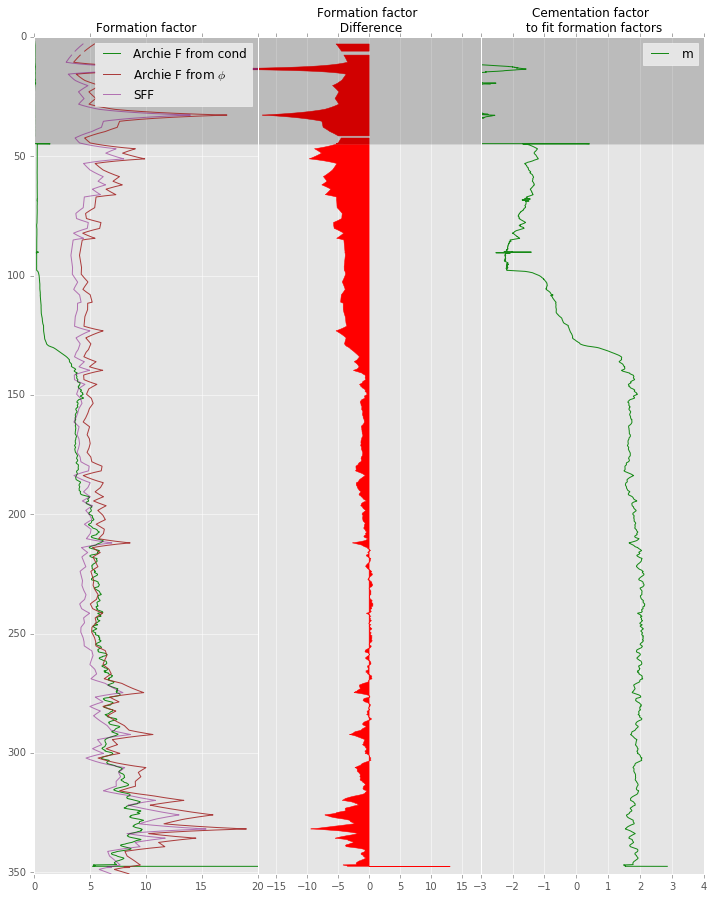

In [16]:
fig = plt.figure(figsize=(12,15))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

#plt.figtext(.1, .05, 'E1 = %s Fluid probe with casing \nE2 = %s Fluid probe \n G = %s Induction probe'%(in_electric[0],in_electric[1],in_gamma))

#Cementation factor
m=2
a=1 #a-factor is close to unity as expected for a sediment with small clay content and a low BET value

resistivity_fluid = 1/data['COND_E2'] #TCDS3719
resistivity_chalk = 1/data['COND_G'] #INDG1832

#Formation factors
ax0 = plt.subplot(131)
Ff0 = resistivity_chalk/resistivity_fluid
Ff1 = a/(POR_inter**m)
Ff2 = 0.81*(POR_inter)**-2
well_plot(Ff0,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='Archie F from cond')
well_plot(Ff1,data['DEPTH'], lw=1, alpha=0.9, color= 'brown', label='Archie F from $\phi$')
well_plot(Ff2,data['DEPTH'], lw=1, alpha=0.5, color= 'purple', label='SFF')
plt.title('Formation factor', fontsize = 12)
plt.xlim(0, 20)
plt.legend()
casing_plot()

ax1 = plt.subplot(132) 
plt.title('Formation factor \n Difference', fontsize = 12)
diff_form=resistivity_chalk/resistivity_fluid-a/(POR_inter**m)
ax1.fill_betweenx(data['DEPTH'],diff_form,color= 'red',label='Difference')
ax1.axes.get_yaxis().set_visible(False)
plt.xlim(-18, 18)
plt.ylim(max(data['DEPTH']),0)
casing_plot()

ax2 = plt.subplot(133) 
plt.title('Cementation factor \n to fit formation factors', fontsize = 12)
m_form=(np.log(a*resistivity_fluid/resistivity_chalk))/(np.log(POR_inter))
well_plot(m_form,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='m')
ax2.axes.get_yaxis().set_visible(False)
plt.xlim(-3, 4)
casing_plot()
plt.legend()

plt.show()

Down to 130m we get unrealistic values of $m$.  For depth above 100m it's far off. This is probably related to water saturation variations, $S_W$  and variations in salinity. In the upper part we might have a freshwater aquifer but at a larger depth, maybe from 140m, there might be fossile brine. This is a probable suggestion from the E2 conductivity log. 

## Specific surface and permeability from electric logs

The decreaseing cementation factor from 250m follows decreasing porosity according to e.g. Borai (1987). 


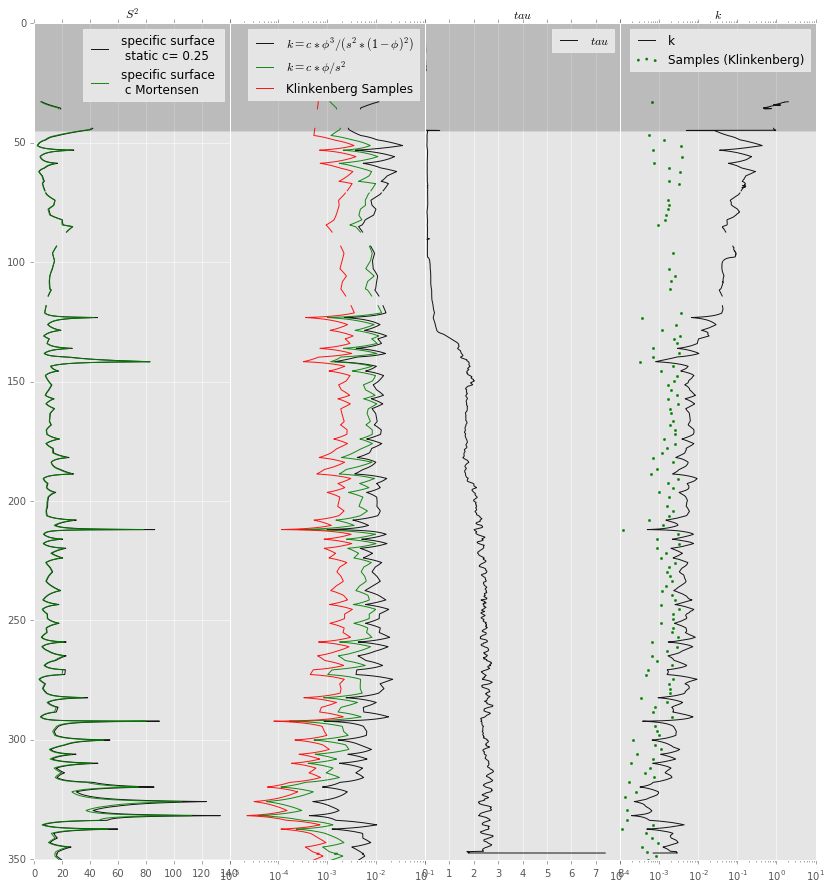

In [17]:
fig = plt.figure(figsize=(14,15))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

ax0 = plt.subplot(141)
c=0.25
plt.title('$S^2$', fontsize = 12)
mortensen_c1 = np.array([mortensen1(POR_mort) for POR_mort in POR_inter])
surface_form_mortensen = (mortensen_c1*(POR_inter**3)/klinkenberg_inter)
surface_form_stat = (c*(POR_inter**3)/klinkenberg_inter)
well_plot(surface_form_stat,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='specific surface \n static c= %s'%c)
well_plot(surface_form_mortensen,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='specific surface \n c Mortensen')
casing_plot()
plt.legend()


ax1 = plt.subplot(142)
k2_inter=(mortensen_c1*POR_inter**3)/(surface_form_mortensen*(1-POR_inter)**2)
k1_inter=mortensen_c1*POR_inter/surface_form_mortensen

well_plot(k1_inter,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='$k=c*\phi^3/(s^2*(1-\phi)^2)$')
well_plot(k2_inter,data['DEPTH'], lw=1, alpha=0.9, color= 'green', label='$k=c*\phi/s^2$')
well_plot(klinkenberg_inter,data['DEPTH'], lw=1, alpha=0.9, color= 'red', label='Klinkenberg Samples')
ax1.set_xscale('log')
ax1.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()

ax2 = plt.subplot(143)
plt.title('$ tau $', fontsize = 12)
tau = Ff0*POR_inter
well_plot(tau,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='$tau$')
ax2.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()

ax3 = plt.subplot(144)
plt.title('$k$', fontsize = 12)
k_final = (mortensen_c1*POR_inter)/(tau*surface_form_mortensen)
well_plot(k_final,data['DEPTH'], lw=1, alpha=0.9, color= 'black', label='k')
ax3.scatter(klinkenberg_samples, data['DEPTH'][mask_PERM],color='green',marker='.',label='Samples (Klinkenberg)')
ax3.axes.get_yaxis().set_visible(False)
casing_plot()
plt.legend()

ax3.set_xscale('log')

plt.legend()

/Users/tobiasstal/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


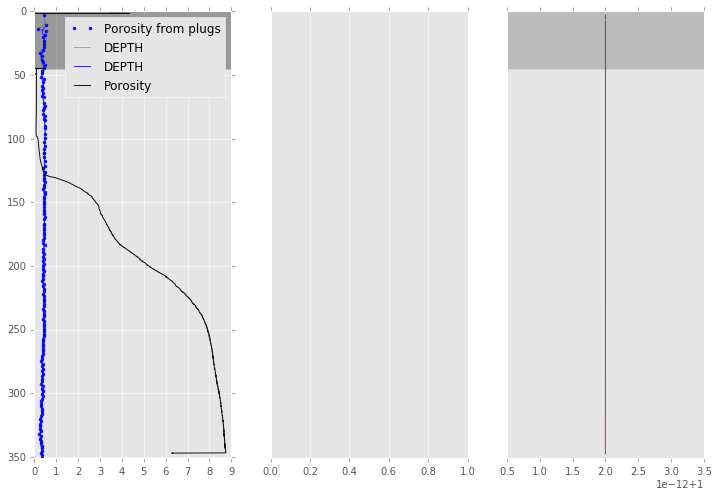

In [14]:
#Archie's porosity

ax1 = plt.subplot(132)
Ct = data['COND_E2']
a = 0.6 # Find for chalk
Cw = data['COND_E1']
m = 2.36 # Check Olsen paper, Witthüser  et al: 2.36
Sw = 1 # Find temperature formula
n = 2 #Wettability

#Interpolated plug data
ax0 = plt.subplot(131)
mask_POR = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask_POR],data['DEPTH'][mask_POR],'.b', alpha=0.9,label='Porosity from plugs')
plt.plot(POR_inter,data['DEPTH'],'b-', alpha=0.3)
well_plot(smooth_filter(POR_inter,500),data['DEPTH'], alpha=0.8,color= 'blue')
plt.grid()
plt.legend()
casing_plot()

Archies_porosity =(Ct*a/(Cw*Sw**n)**(1/m))
well_plot(Archies_porosity,color='k', label='Porosity')

ax1.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()


#Archies porosity with samples and differences
ax2 = plt.subplot(133)
ax2.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

surface_from_cond = resistivity_fluid/((POR_inter**m_form)*resistivity_chalk)
well_plot(surface_from_cond,data['DEPTH'], lw=1, alpha=0.9, color= 'red', label='specific surface \n from conductivity')
